# Decile Analysis

> Gain curve, lift curve, and decile analysis

- skip_exec: true


## Train a model and get predictions


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder


In [ ]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True, parser="pandas")
rng = np.random.RandomState(seed=42)

categorical_columns = ["pclass", "sex", "embarked"]
numerical_columns = ["age", "sibsp", "parch", "fare"]

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


In [ ]:
categorical_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
rf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['pclass', 'sex',
                                                   'embarked']),
                                                 ('num', SimpleImputer(),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare'])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")


RF train accuracy: 0.972
RF test accuracy: 0.787


In [ ]:
y_test = y_test.astype(int)


In [ ]:
y_test.mean()


0.38109756097560976

## Gain Curve


To calculate the gain for a given proportion of a sample, we first sort the true `y` values by the size of the model's predicted probability. We count the number of positives inside this proportion and divide it by the total number of positives inside the whole sample.

$$
\text{gain} = \frac{\text{\# positives in subset}}{\text{\# positives in sample}}
$$


In [ ]:
def plot_gain_curve(preds, ys, title="Gain Curve", ax=None):
    sorted_ys = ys.iloc[np.argsort(preds)[::-1]]
    gain_values = sorted_ys.cumsum() / sum(sorted_ys == 1)
    if ax is None:
        ax = plt.axes()
    ax.set_xlabel("Proportion of sample")
    ax.set_ylabel("Gain")
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", ax=ax)
    sns.lineplot(x=[x / len(gain_values) for x in range(len(gain_values))], y=gain_values, ax=ax)

In [ ]:
fig = plt.figure(figsize=(12, 3))
gs = fig.add_gridspec(1, 4, hspace=0.2, wspace=0.2)
axes = gs.subplots(sharex="col", sharey="row")
preds_perfect = y_test
plot_gain_curve(preds_perfect, y_test, ax=axes[0], title="Perfect Gain Curve")
preds_test = rf.predict_proba(X_test)[:, 1]
plot_gain_curve(preds_test, y_test, ax=axes[1], title="Random Forest Gain Curve")
preds_random = np.random.rand(len(y_test))
plot_gain_curve(preds_random, y_test, ax=axes[2], title="Random Gain Curve")
preds_opposite = y_test.apply(lambda x: not (x) * 1)
plot_gain_curve(preds_opposite, y_test, ax=axes[3], title="Opposite Gain Curve")
for ax in fig.get_axes():
    ax.label_outer()
plt.show()

AttributeError: 'GridSpec' object has no attribute 'subplots'

<Figure size 864x216 with 0 Axes>

Within our test set 38% of people died. A theoretically perfect model would be able to find you those 38% by returning postive values for 38% of the dataset for a 100% "gain". In practice to get that 38% you have to accept some false positives. It takes more than 38% of the dataset to get you the 38% of people who died. In fact it takes 100% to get all the way there because the model will also return false negatives with very low predicted probabilities of dying. However we can see it still does better than random, and for completeness sake, a model that always returns the wrong answer.


## Lift Curve


To calculate the lift for a given proportion of the sample, we find the ratio of positives inside this subset and divide it by the ratio of positives inside the whole sample.

$$
\text{lift} = \dfrac{\dfrac{\text{\# positives in subset}}{\text{\# positives in sample}}}{\dfrac{\text{\# positives in sample}}{\text{\# total sample}}}
$$


In [ ]:
def plot_lift(y_proba, y_real, ax=None, title="Lift Curve"):
    aux_df = pd.DataFrame.from_dict({"y_real": y_real, "y_proba": y_proba})
    aux_df = aux_df.sort_values("y_proba", ascending=False)
    # Find the total positive ratio of the whole dataset
    total_positive_ratio = sum(aux_df["y_real"] == 1) / aux_df.shape[0]
    # For each line of data, get the ratio of positives of the given subset and calculate the lift
    lift_values = []
    for i in aux_df.index:
        threshold = aux_df.loc[i]["y_proba"]
        subset = aux_df[aux_df["y_proba"] >= threshold]
        subset_positive_ratio = sum(subset["y_real"] == 1) / subset.shape[0]
        lift = subset_positive_ratio / total_positive_ratio
        lift_values.append(lift)
    if ax == None:
        ax = plt.axes()
    ax.set_xlabel("Proportion of sample")
    ax.set_ylabel("Lift")
    ax.set_title(title)
    ax.set_xlim(0, 1)
    sns.lineplot(x=[x / len(lift_values) for x in range(len(lift_values))], y=lift_values, ax=ax)
    ax.axhline(1, linestyle="dashed", linewidth=1)

In [ ]:
1 / 0.38


2.6315789473684212

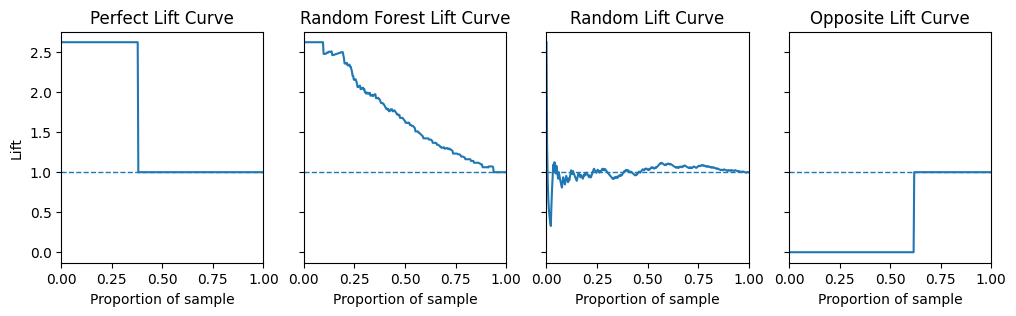

In [ ]:
fig = plt.figure(figsize=(12, 3))
gs = fig.add_gridspec(1, 4, hspace=0.2, wspace=0.2)
axes = gs.subplots(sharex="col", sharey="row")
preds_perfect = y_test
plot_lift(preds_perfect, y_test, ax=axes[0], title="Perfect Lift Curve")
preds_test = rf.predict_proba(X_test)[:, 1]
plot_lift(preds_test, y_test, ax=axes[1], title="Random Forest Lift Curve")
preds_random = np.random.rand(len(y_test))
plot_lift(preds_random, y_test, ax=axes[2], title="Random Lift Curve")
preds_opposite = y_test.apply(lambda x: not (x) * 1)
plot_lift(preds_opposite, y_test, ax=axes[3], title="Opposite Lift Curve")
for ax in fig.get_axes():
    ax.label_outer()
plt.show()

As 38% of values in the test set are postive the highest lift value possible is $\frac{1}{0.38} = 2.63$.

A perfect model will have a lift value of 2.63 for the first 38% of the dataset since there are 2.63 times as many positives in the first 38% of the dataset as there are in the whole dataset (Remember the data has been sorted by the predicted probability of the model).

A model that is no better than random will have a lift value of 1.


## Decile Analysis


Decile analysis is a method of analyzing the performance of a model by dividing the data into 10 equal parts, or deciles. The deciles are ranked from 1 to 10, with 1 being what the model thinks is "best" and 10 being the model thinks is "worst" . The deciles are then analyzed to determine the performance of the model.

For instance, we may be ranking the deciles by how likely a model thinks they are to buy a product if shown and advert, or default on a loan.

So we would:

1. Get the predicted probabilities from the model
2. Sort them in descending order
3. Divide the data into 10 parts with an equal number of rows in each part
4. Compute the number of actually positive cases in each decile
5. From this it is possible to derive gain and lift values for each decile


In [ ]:
preds_test = rf.predict_proba(X_test)[:, 1]

In [ ]:
df = pd.DataFrame({"y_proba": preds_test, "y_real": y_test})
df = df.sort_values("y_proba", ascending=False)
df = df.reset_index(drop=True)
df["decile"] = pd.qcut(df.index, 10, labels=False)

In [ ]:
df


,y_proba,y_real,decile
0,1.0,1,0
1,1.0,1,0
2,1.0,1,0
3,1.0,1,0
4,1.0,1,0
...,...,...,...
323,0.0,0,9
324,0.0,0,9
325,0.0,0,9
326,0.0,0,9


In [ ]:
decile_df = pd.DataFrame()
decile_df["decile"] = df["decile"].unique()
decile_df["total"] = df.groupby("decile")["y_real"].count()
decile_df["total_cum"] = decile_df["total"].cumsum()
decile_df["pct_cum"] = decile_df["total_cum"] / df.shape[0]
decile_df["positives"] = df.groupby("decile")["y_real"].sum()
decile_df["pos_rate"] = decile_df["positives"] / decile_df["total"]
decile_df["pos_pct"] = decile_df["positives"] / df["y_real"].sum()
decile_df["gain"] = decile_df["pos_pct"].cumsum()
decile_df["lift"] = decile_df["gain"] / decile_df["pct_cum"]
decile_df[["prob_min", "prob_max"]] = df.groupby("decile")["y_proba"].agg(["min", "max"])
decile_df = decile_df.set_index("decile")
decile_df = decile_df.round(2)
decile_df


,total,total_cum,pct_cum,positives,pos_rate,pos_pct,gain,lift,prob_min,prob_max
decile,,,,,,,,,,
0,33,33,0.1,32,0.97,0.26,0.26,2.54,0.95,1.00
1,33,66,0.2,29,0.88,0.23,0.49,2.43,0.83,0.95
2,33,99,0.3,16,0.48,0.13,0.62,2.04,0.64,0.81
3,32,131,0.4,15,0.47,0.12,0.74,1.84,0.45,0.63
4,33,164,0.5,11,0.33,0.09,0.82,1.65,0.28,0.45
5,33,197,0.6,5,0.15,0.04,0.86,1.44,0.19,0.28
6,32,229,0.7,6,0.19,0.05,0.91,1.31,0.11,0.19
7,33,262,0.8,4,0.12,0.03,0.94,1.18,0.05,0.11
8,33,295,0.9,3,0.09,0.02,0.97,1.08,0.02,0.05


## References and Links

- Loads taken from [here](https://github.com/vinyluis/Articles/tree/main/Decile%20Gain%20Lift)
- Nice introduction to decile analysis [here](https://www.kdnuggets.com/2021/07/lost-art-decile-analysis.html)
- The [scikit-plot library](https://github.com/reiinakano/scikit-plot) offers a lot of this out of the box
